<a href="https://colab.research.google.com/github/Cecile-shim/DNA-Image-Analysis/blob/main/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Colab


In [28]:
import os

os.chdir("/content/drive/My Drive/Coding/unet/tensorflow-unet-labelme")

In [3]:
!apt-get install python3-pyqt5
!apt-get install python3-pyside
!pip install pyside2
!pip install labelme

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5designer5 libqt5gui5 libqt5help5 libqt5network5 libqt5printsupport5 libqt5sql5
  libqt5sql5-sqlite libqt5svg5 libqt5test5 libqt5widgets5 libqt5xml5 libwacom-bin libwacom-common
  libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1 libxcb-render-util0 libxcb-util1
  libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0 python3-pyqt5.sip
  qt5-gtk-platformtheme qttranslations5-l10n
Suggested packages:
  qt5-image-formats-plugins qtwayland5
The following NEW packages will be installed:
  libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5designer5 libqt5gui5 libqt5help5 libqt5network5 libqt5printsupport5 libqt5sql5
  libqt5sql5-sqlite libqt5svg5 libqt5test5 libqt5widgets5 libqt5xm

In [ ]:
'''
if you want to make result objects white color, write the under codes
to the direction /usr/local/lib/python3.10/dist-packages/labelme/utils/_io.py
'''

# colormap = np.ones((255,3), dtype=float)
# colormap[0] = [0,0,0]
# lbl_pil.putpalette((colormap * 255).astype(np.uint8).flatten())

In [4]:
!chmod +x labelme2voc.py
!make voc

./labelme2voc.py datasets/train datasets/train_voc --labels datasets/labels.txt
Creating dataset: datasets/train_voc
class_names: ('_background_', 'm13')
Saved class_names: datasets/train_voc/class_names.txt
Generating dataset from: datasets/train/1.json
Generating dataset from: datasets/train/11.json
Generating dataset from: datasets/train/15.json
Generating dataset from: datasets/train/3.json
Generating dataset from: datasets/train/5.json
Generating dataset from: datasets/train/9.json
python voc_annotation.py
Generate txt in ImageSets.
train and val size 6
train size 5
Generate txt in ImageSets done.


### Augmentation

In [5]:
import math
import glob
import numpy as np
import random
from PIL import Image, ImageEnhance
import cv2

image_path = 'datasets/train_voc/JPEGImages/'
label_path = 'datasets/train_voc/SegmentationClassPNG/'
image_list = [file for file in glob.glob(image_path+'*.jpg')]
label_list = [file for file in glob.glob(label_path+'*.png')]
print(image_list)
print(label_list)


for file in image_list:
  image = Image.open(file).convert("L")
  image.save(file)
  i = file.split('/')[-1].split('.')[0]
  #밝기
  enhancer = ImageEnhance.Brightness(image)
  brightness_image = enhancer.enhance(1.4)
  brightness_image.save(image_path+'{}_bright.jpg'.format(i))
  #좌우 대칭
  horizonal_flip_image = image.transpose(Image.FLIP_LEFT_RIGHT)
  horizonal_flip_image.save(image_path+'{}_hflip.jpg'.format(i))
  #상하 대칭
  vertical_flip_image = image.transpose(Image.FLIP_TOP_BOTTOM)
  vertical_flip_image.save(image_path+'{}_vflip.jpg'.format(i))
  #회전
  rotate_image = image.rotate(30)
  rotate_image.save(image_path+'{}_rotate.jpg'.format(i))
  #기울기
  cx,cy = 0, 0.2
  shear_image = image.transform(image.size, method=Image.AFFINE,
                                data=[1,cx,0,cy,1,0])
  shear_image.save(image_path+'{}_shear.jpg'.format(i))

for file in label_list:
  label = Image.open(file)
  i = file.split('/')[-1].split('.')[0]
  #밝기
  brightness_label = label
  brightness_label.save(label_path+'{}_bright.png'.format(i))
  #좌우 대칭
  horizonal_flip_label = label.transpose(Image.FLIP_LEFT_RIGHT)
  horizonal_flip_label.save(label_path+'{}_hflip.png'.format(i))
  #상하 대칭
  vertical_flip_label = label.transpose(Image.FLIP_TOP_BOTTOM)
  vertical_flip_label.save(label_path+'{}_vflip.png'.format(i))
  #회전
  rotate_label = label.rotate(30)
  rotate_label.save(label_path+'{}_rotate.png'.format(i))
  #기울기
  cx,cy = 0, 0.2
  shear_label = label.transform(label.size, method=Image.AFFINE,
                                data=[1,cx,0,cy,1,0])
  shear_label.save(label_path+'{}_shear.png'.format(i))


['datasets/train_voc/JPEGImages/1.jpg', 'datasets/train_voc/JPEGImages/11.jpg', 'datasets/train_voc/JPEGImages/15.jpg', 'datasets/train_voc/JPEGImages/3.jpg', 'datasets/train_voc/JPEGImages/5.jpg', 'datasets/train_voc/JPEGImages/9.jpg']
['datasets/train_voc/SegmentationClassPNG/1.png', 'datasets/train_voc/SegmentationClassPNG/11.png', 'datasets/train_voc/SegmentationClassPNG/15.png', 'datasets/train_voc/SegmentationClassPNG/3.png', 'datasets/train_voc/SegmentationClassPNG/5.png', 'datasets/train_voc/SegmentationClassPNG/9.png']


In [6]:
import random
import math
import glob
import numpy as np
from PIL import Image, ImageEnhance
import cv2

TRAINVAL_PERCENT = 1
TRAIN_PERCENT = 0.9
DATASET_PATH = 'datasets/train_voc'


def get_file_names(dir, filter="*.png"):
    names = []
    for file_path in glob.glob(os.path.join(dir, filter)):
        filename = os.path.basename(file_path)
        names.append(filename)
    return names



print("Generate txt in ImageSets.")

seg_filepath = os.path.join(DATASET_PATH, 'SegmentationClassPNG')
saveBasePath = os.path.join(DATASET_PATH, 'ImageSets/Segmentation')
if not os.path.exists(saveBasePath):
  os.makedirs(saveBasePath)

total_seg = get_file_names(seg_filepath)

num = len(total_seg)
seg_list = range(num)
tv = int(num * TRAINVAL_PERCENT)
tr = int(tv * TRAIN_PERCENT)
trainval = random.sample(seg_list, tv)
train = random.sample(trainval, tr)

print("train and val size", tv)
print("train size", tr)

trainval_txt = open(os.path.join(saveBasePath, 'trainval.txt'),
                        'w',
                        encoding="utf8")
test_txt = open(os.path.join(saveBasePath, 'test.txt'),
                    'w',
                    encoding="utf8")
train_txt = open(os.path.join(saveBasePath, 'train.txt'),
                     'w',
                     encoding="utf8")
val_txt = open(os.path.join(saveBasePath, 'val.txt'), 'w', encoding="utf8")

for i in seg_list:
  name = total_seg[i][:-4] + '\n'
  if i in trainval:
    trainval_txt.write(name)
    if i in train:
      train_txt.write(name)
    else:
      val_txt.write(name)
  else:
    test_txt.write(name)

trainval_txt.close()
train_txt.close()
val_txt.close()
test_txt.close()

print("Generate txt in ImageSets done.")

Generate txt in ImageSets.
train and val size 36
train size 32
Generate txt in ImageSets done.


### Parameters


In [7]:
import tensorflow as tf
import warnings

In [25]:
NUM_CLASSES = 2 # class number + 1 (background)
INPUT_SHAPE = [512, 512, 3] # (H, W, C) # if you train other dataset, change to [480, 640, 3]
BATCH_SIZE = 2
EPOCHS = 60
VAL_SUBSPLITS = 1

### Datasets


In [26]:
import random
import math
import glob
import numpy as np
import random
from PIL import Image, ImageEnhance
import cv2

def cvtColor(image):
    if len(np.shape(image)) == 3 and np.shape(image)[-2] == 3:
        return image
    else:
        image = image.convert('RGB')
        return image


def normalize(image):
    image = image / 127.5 - 1
    return image


def resize_image(image, size):
    iw, ih = image.size
    w, h = size

    scale = min(w / iw, h / ih)
    nw = int(iw * scale)
    nh = int(ih * scale)

    image = image.resize((nw, nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128, 128, 128))
    new_image.paste(image, ((w - nw) // 2, (h - nh) // 2))

    return new_image, nw, nh


def resize_label(image, size):
    iw, ih = image.size
    w, h = size

    scale = min(w / iw, h / ih)
    nw = int(iw * scale)
    nh = int(ih * scale)

    image = image.resize((nw, nh), Image.NEAREST)
    new_image = Image.new('L', size, (0))
    new_image.paste(image, ((w - nw) // 2, (h - nh) // 2))

    return new_image, nw, nh


class UnetDataset(tf.keras.utils.Sequence):

    def __init__(self, annotation_lines, input_shape, batch_size, num_classes,
                 train, dataset_path):
        self.annotation_lines = annotation_lines
        self.length = len(self.annotation_lines)
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.train = train
        self.dataset_path = dataset_path

    def __len__(self):
        return math.ceil(len(self.annotation_lines) / float(self.batch_size))

    def __getitem__(self, index):
        images = []
        targets = []
        for i in range(index * self.batch_size, (index + 1) * self.batch_size):
            i = i % self.length
            name = self.annotation_lines[i].split()[0]
            jpg = Image.open(
                os.path.join(os.path.join(self.dataset_path, "JPEGImages"),
                             name + ".jpg"))
            png = Image.open(
                os.path.join(
                    os.path.join(self.dataset_path, "SegmentationClassPNG"),
                    name + ".png"))

            jpg, png = self.process_data(jpg,
                                         png,
                                         self.input_shape,
                                         random=self.train)

            images.append(jpg)
            targets.append(png)

        #images, targets = self.augment(images,targets)

        images = np.array(images)
        targets = np.array(targets)
        return images, targets

    def rand(self, a=0, b=1):
        return np.random.rand() * (b - a) + a

    def process_data(self, image, label, input_shape, random=True):
        image = cvtColor(image)
        # label = cvtColor(label)
        label = Image.fromarray(np.array(label))
        h, w, _ = input_shape

        # resize
        image, _, _ = resize_image(image, (w, h))
        label, _, _ = resize_label(label, (w, h))

        if random:
            # flip
            flip = self.rand() < .5
            if flip:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                label = label.transpose(Image.FLIP_LEFT_RIGHT)

        # np
        image = np.array(image, np.float32)
        image = normalize(image)

        label = np.array(label)
        label[label >= self.num_classes] = self.num_classes

        return image, label

In [29]:
dataset_path = 'datasets/train_voc'

# read dataset txt files
with open(os.path.join(dataset_path, "ImageSets/Segmentation/train.txt"),
          "r",
          encoding="utf8") as f:
    train_lines = f.readlines()

with open(os.path.join(dataset_path, "ImageSets/Segmentation/val.txt"),
          "r",
          encoding="utf8") as f:
    val_lines = f.readlines()

train_batches = UnetDataset(train_lines, INPUT_SHAPE, BATCH_SIZE, NUM_CLASSES,
                            True, dataset_path)
val_batches = UnetDataset(val_lines, INPUT_SHAPE, BATCH_SIZE, NUM_CLASSES,
                          False, dataset_path)


STEPS_PER_EPOCH = len(train_lines) // BATCH_SIZE
VALIDATION_STEPS = len(val_lines) // BATCH_SIZE // VAL_SUBSPLITS
print(STEPS_PER_EPOCH)

16


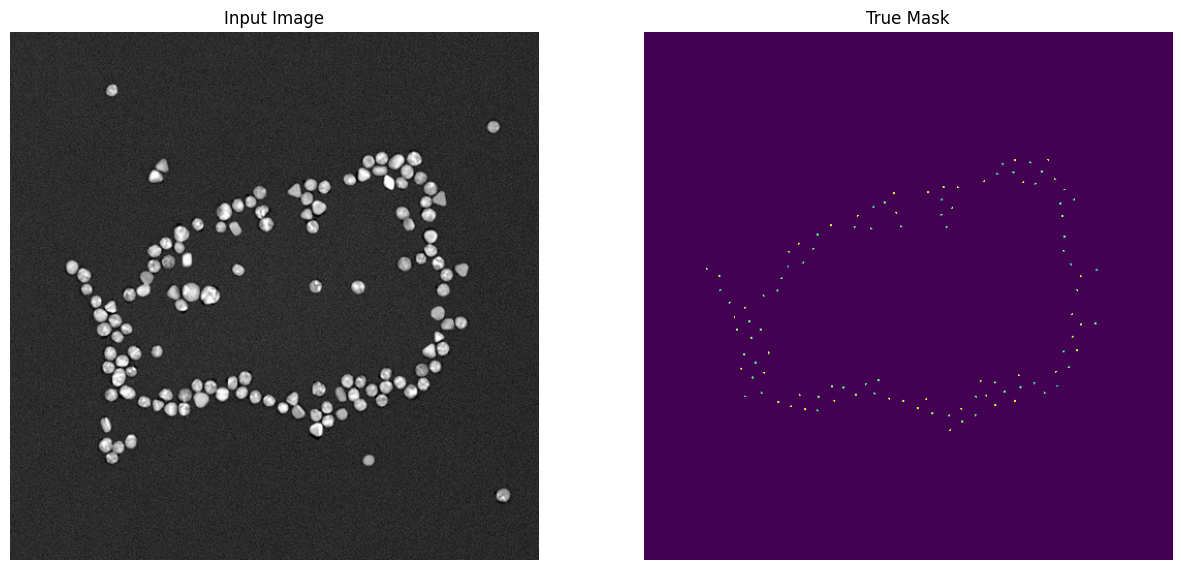

In [30]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

images, masks = train_batches.__getitem__(0)
sample_image, sample_mask = images[1], masks[1]
sample_mask = sample_mask[..., tf.newaxis]
display([sample_image, sample_mask])

### Model


#### Helper methods


In [31]:
# https://www.tensorflow.org/tutorials/generative/pix2pix
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters,
                                        size,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


#### Base model


In [32]:
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                               include_top=False)

# activation은 여기 layer로 이용
layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',  # 4x4
]
base_model_outputs = [
    base_model.get_layer(name).output for name in layer_names
]

# feature extraction model 생성
down_stack = tf.keras.Model(inputs=base_model.input,
                            outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),  # 32x32 -> 64x64
]


def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

    # Downsampling 과정
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling과 Connection 생성
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # 해당 모델의 마지막 layer
    last = tf.keras.layers.Conv2DTranspose(filters=output_channels,
                                           kernel_size=3,
                                           strides=2,
                                           padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


#### Compile


In [33]:
model = unet_model(output_channels=NUM_CLASSES)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        [(None, 256, 256, 96),       1841984   ['input_4[0][0]']             
                              (None, 128, 128, 144),                                              
                              (None, 64, 64, 192),                                                
                              (None, 32, 32, 576),                                                
                              (None, 16, 16, 320)]                                                
                                                                                            

#### Callbacks

In [34]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([
            sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))
        ])


from IPython.display import clear_output


class DisplayCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))


class ModelCheckpointCallback(tf.keras.callbacks.Callback):

    def __init__(self,
                 filepath,
                 monitor='val_loss',
                 verbose=0,
                 save_best_only=False,
                 save_weights_only=False,
                 mode='auto',
                 period=1):
        super(ModelCheckpointCallback, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn(
                'ModelCheckpoint mode %s is unknown, '
                'fallback to auto mode.' % (mode), RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn(
                        'Can save best model only with %s available, '
                        'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print(
                                '\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                                ' saving model to %s' %
                                (epoch + 1, self.monitor, self.best, current,
                                 filepath))
                        self.best = current
                        if self.save_weights_only:
                            self.model.save_weights(filepath, overwrite=True)
                        else:
                            self.model.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s did not improve' %
                                  (epoch + 1, self.monitor))
            else:
                if self.verbose > 0:
                    print('\nEpoch %05d: saving model to %s' %
                          (epoch + 1, filepath))
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
                else:
                    self.model.save(filepath, overwrite=True)

### Train

1/1 [==============================] - 0s 26ms/step


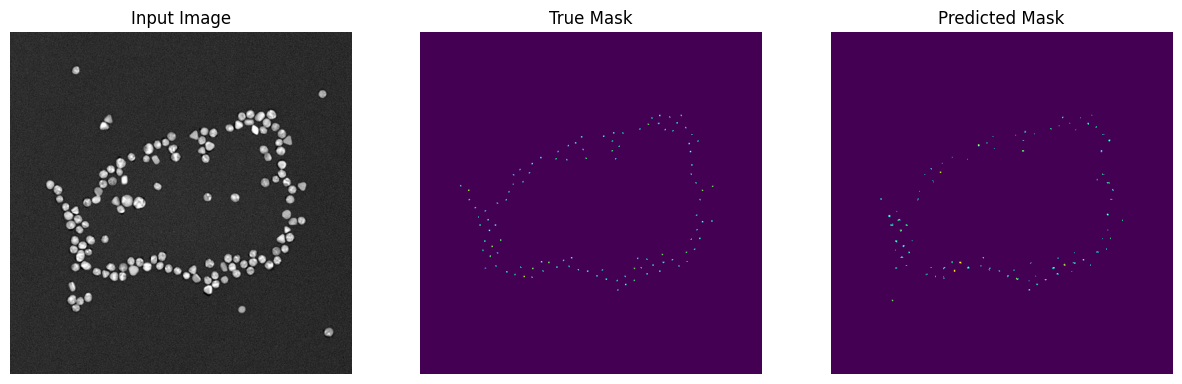


Sample Prediction after epoch 60

16/16 [==============================] - 7s 422ms/step - loss: 0.0115 - accuracy: 0.9953 - val_loss: 0.0082 - val_accuracy: 0.9967


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [35]:
displayCallback = DisplayCallback()

if not os.path.exists('logs'):
    os.makedirs('logs')
checkpointCallback = ModelCheckpointCallback(
    'logs/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True,
    period=1)

model_history = model.fit(train_batches,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[displayCallback, checkpointCallback])

model.save('logs/the-last-model.h5', overwrite=True)

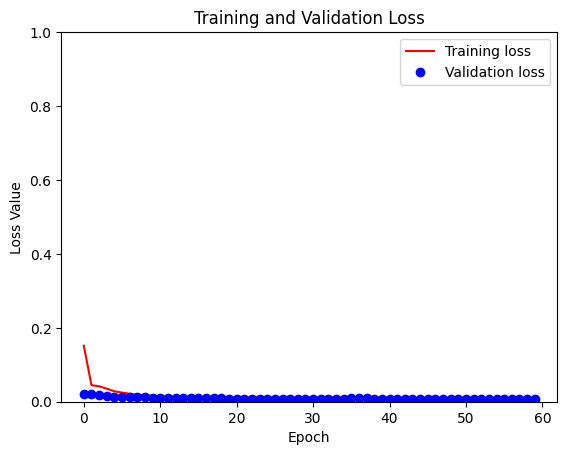

In [36]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Load Model


In [37]:
os.chdir("/content/drive/My Drive/Coding/unet/tensorflow-unet-labelme")
model_path = 'logs/the-last-model.h5'
model.load_weights(model_path)
print('{} model loaded.'.format(model_path))

import copy

# colors = [(0, 0, 0), (128,0,0), (0, 128, 0), (128, 128, 0), (0, 0, 128),
#           (128, 0, 128), (0, 128, 128), (128, 128, 128),
#           (64, 0, 0), (192, 0, 0), (64, 128, 0), (192, 128, 0), (64, 0, 128),
#           (192, 0, 128), (64, 128, 128), (192, 128, 128), (0, 64, 0),
#           (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128),
#           (128, 64, 12)]

colormap = np.ones((255,3), dtype=float)
colormap[0] = [0,0,0]


def detect_image(image_path):
    image = Image.open(image_path)
    image = cvtColor(image)

    old_img = copy.deepcopy(image)
    ori_h = np.array(image).shape[0]
    ori_w = np.array(image).shape[1]

    image_data, nw, nh = resize_image(image, (INPUT_SHAPE[1], INPUT_SHAPE[0]))

    image_data = normalize(np.array(image_data, np.float32))

    image_data = np.expand_dims(image_data, 0)

    pr = model.predict(image_data)[0]

    pr = pr[int((INPUT_SHAPE[0] - nh) // 2) : int((INPUT_SHAPE[0] - nh) // 2 + nh), \
            int((INPUT_SHAPE[1] - nw) // 2) : int((INPUT_SHAPE[1] - nw) // 2 + nw)]

    pr = cv2.resize(pr, (ori_w, ori_h), interpolation=cv2.INTER_LINEAR)

    pr = pr.argmax(axis=-1)

    # seg_img = np.zeros((np.shape(pr)[0], np.shape(pr)[1], 3))
    # for c in range(NUM_CLASSES):
    #     seg_img[:, :, 0] += ((pr[:, :] == c ) * colors[c][0]).astype('uint8')
    #     seg_img[:, :, 1] += ((pr[:, :] == c ) * colors[c][1]).astype('uint8')
    #     seg_img[:, :, 2] += ((pr[:, :] == c ) * colors[c][2]).astype('uint8')
    seg_img = np.reshape(
        np.array((colormap*255), np.uint8)[np.reshape(pr, [-1])], [ori_h, ori_w, -1])

    image = Image.fromarray(seg_img)
    #image = Image.blend(old_img, image, 0.7)

    return image

logs/the-last-model.h5 model loaded.


### Test


['19_100_75.jpg', '20_100_80.jpg', '17_100_60.jpg', '16_100_50.jpg', '15_100_100.jpg', '14_100_70.jpg', '18_100_75.jpg', '13_100_70.jpg', '5_200_474.jpg', '1_200_474.jpg', '8_500_712.jpg', '2_500_944.jpg', '6_500_944.jpg', '4_500_944.jpg', '9_500_712.jpg', '11_100_578.jpg', '3_200_474.jpg', '12_200_570.jpg', '7_1000_1138.jpg', '10_500_712.jpg']
1/1 [==============================] - 0s 24ms/step


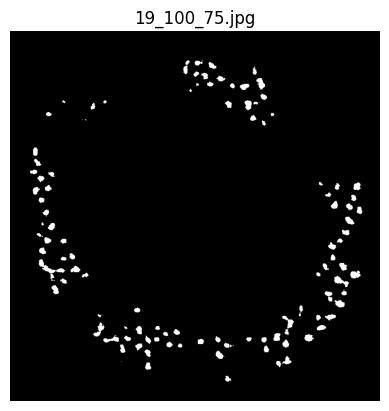

1/1 [==============================] - 0s 22ms/step


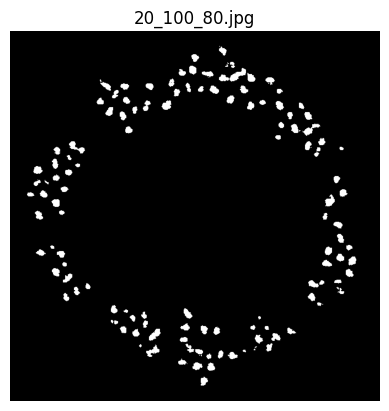

1/1 [==============================] - 0s 23ms/step


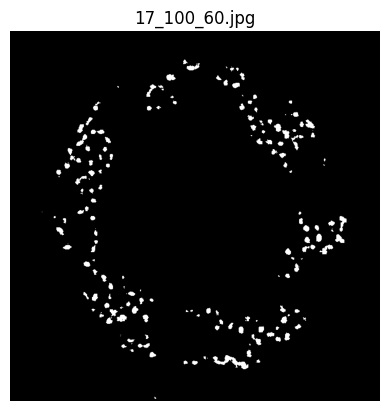

1/1 [==============================] - 0s 26ms/step


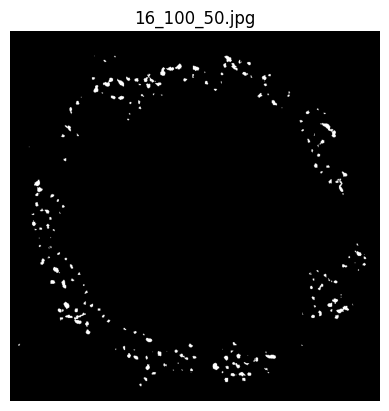

1/1 [==============================] - 0s 24ms/step


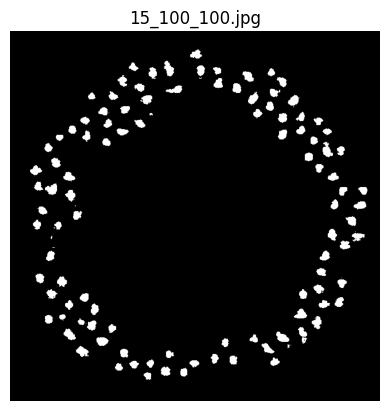

1/1 [==============================] - 0s 23ms/step


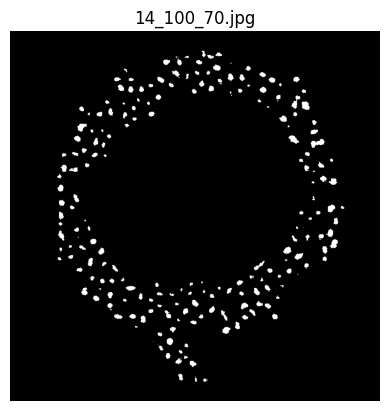

1/1 [==============================] - 0s 24ms/step


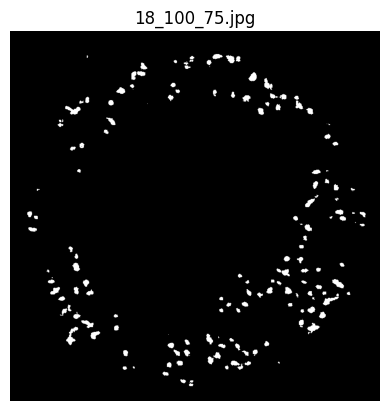

1/1 [==============================] - 0s 23ms/step


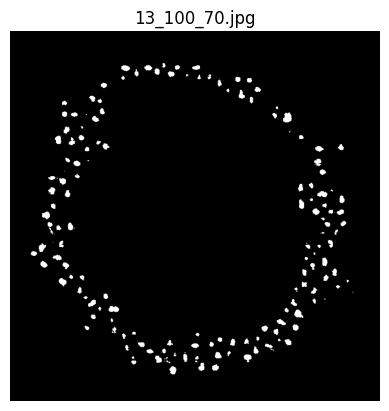

1/1 [==============================] - 0s 35ms/step


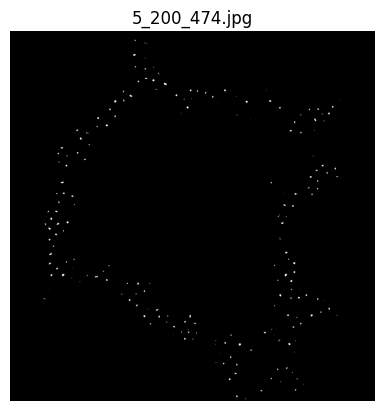

1/1 [==============================] - 0s 38ms/step


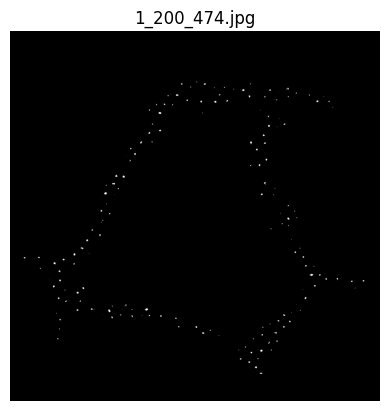

1/1 [==============================] - 0s 25ms/step


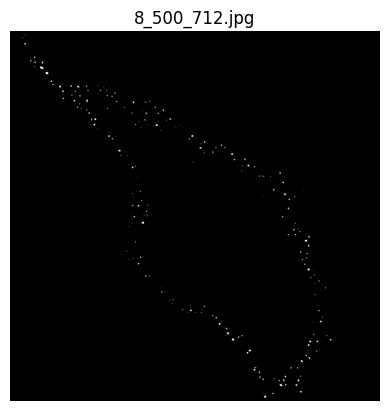

1/1 [==============================] - 0s 26ms/step


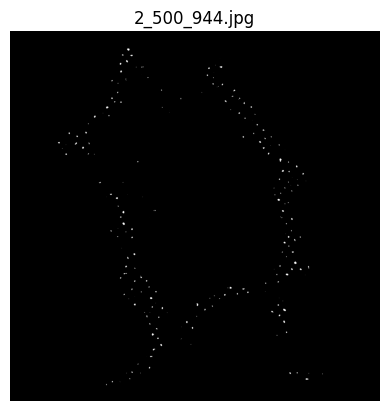

1/1 [==============================] - 0s 23ms/step


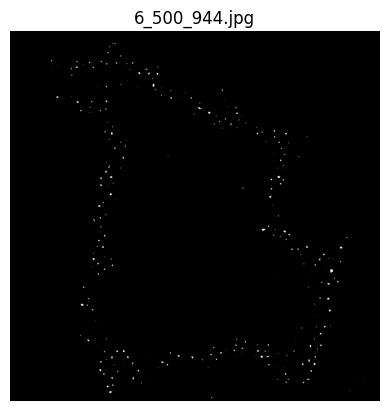

1/1 [==============================] - 0s 23ms/step


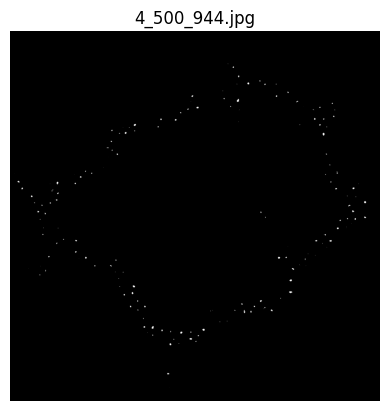

1/1 [==============================] - 0s 24ms/step


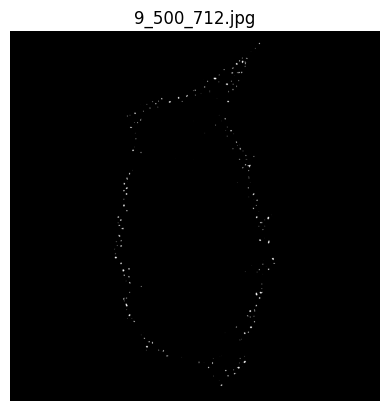

1/1 [==============================] - 0s 32ms/step


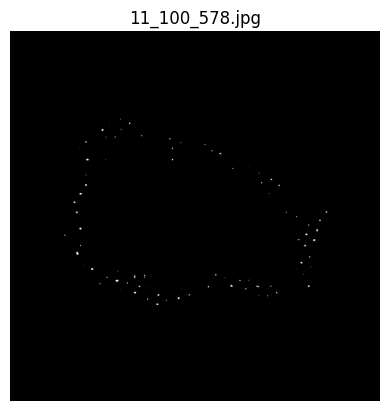

1/1 [==============================] - 0s 24ms/step


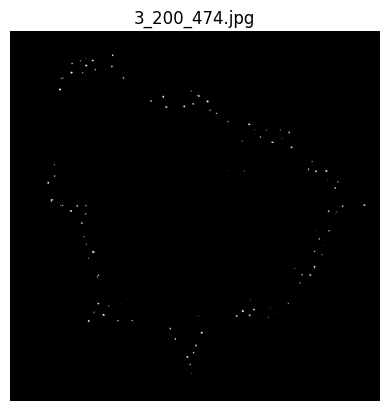

1/1 [==============================] - 0s 23ms/step


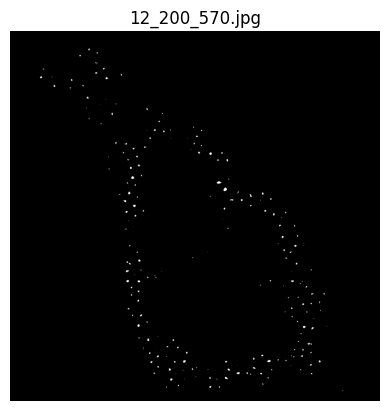

1/1 [==============================] - 0s 24ms/step


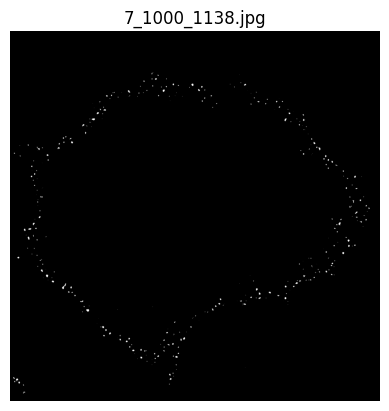

1/1 [==============================] - 0s 28ms/step


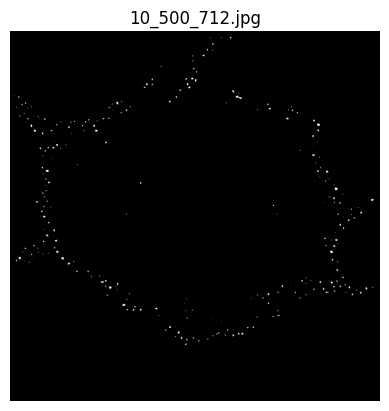

In [38]:
from PIL import Image

os.chdir("/content/drive/My Drive/Coding/unet/tensorflow-unet-labelme/datasets/test/")
img_list = glob.glob("*.jpg")
# for fish-sperm DNA, change jpg to png

print(img_list)

for img in img_list:
  fname, ext = os.path.splitext(img)
  image = detect_image(img)
  plt.imshow(image)
  plt.title(img)
  plt.axis('off')
  plt.show()
  image.save('result/'+fname+'.png')
  # for fish-sperm DNA, change fname to fname.split('.')[0] -> only file number
